# PK file containing 33 columns

In [1]:
import numpy as np
import matplotlib.pyplot as plt

camb = np.genfromtxt('./camb_regpt/planck18_matterpower.dat')

In [2]:
from scipy.interpolate import interp1d
import itertools

kk = np.linspace(0.01,0.41,500)

k = camb[:,0]

pb2d_0 = camb[:,5]
intp = interp1d(k,pb2d_0,kind='nearest')
pb2d = intp(kk)

pb2v_0 = camb[:,6]
intp = interp1d(k,pb2v_0,kind='nearest')
pb2v = intp(kk)

pb22_0 = camb[:,7]
intp = interp1d(k,pb22_0,kind='nearest')
pb22 = intp(kk)

pbs2d_0 = camb[:,8]
intp = interp1d(k,pbs2d_0,kind='nearest')
pbs2d = intp(kk)

pbs2v_0 = camb[:,9]
intp = interp1d(k,pbs2v_0,kind='nearest')
pbs2v = intp(kk)

pb2s2_0 = camb[:,10]
intp = interp1d(k,pb2s2_0,kind='nearest')
pb2s2 = intp(kk)

pbs22_0 = camb[:,11]
intp = interp1d(k,pbs22_0,kind='nearest')
pbs22 = intp(kk)

pb3nl_0 = camb[:,12]
intp = interp1d(k,pb3nl_0,kind='nearest')
pb3nl = intp(kk)

A = np.full((3,3),None)
A0 = np.full((3,3),None)
A0[0,0],A0[0,1],A0[1,1],A0[1,2],A0[2,2] = camb[:,16:21].T
for m,n in itertools.product(range(3),range(3)):
    if A0[m,n] is not None:
        intp = interp1d(k,A0[m,n],kind='nearest')
        A[m,n] = intp(kk)
        
B0 = np.full((4,4,4),None)
B = np.full((4,4,4),None)
B0[0,0,0],B0[0,0,1],B0[0,1,0],B0[0,1,1],\
B0[1,0,0],B0[1,0,1],B0[1,1,0],B0[1,1,1],\
B0[2,0,1],B0[2,1,0],B0[2,1,1],B0[3,1,1] = camb[:,21:33].T
for m,a,b in itertools.product(range(4),range(2),range(2)):
    if B0[m,a,b] is not None:
        intp = interp1d(k,B0[m,a,b],kind='nearest')
        B[m,a,b] = intp(kk)

# Show original A and B

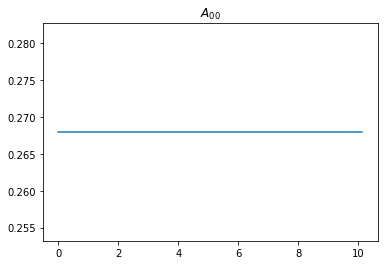

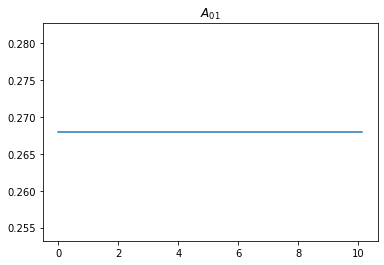

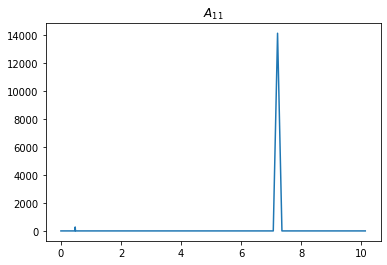

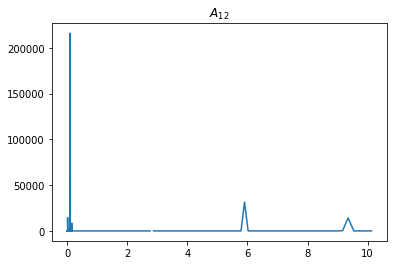

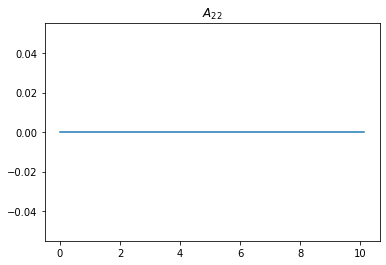

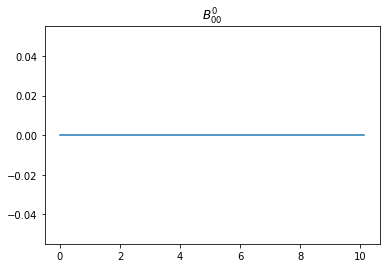

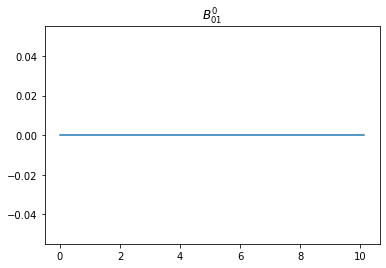

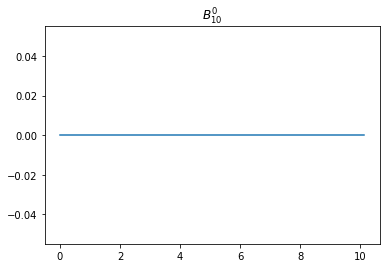

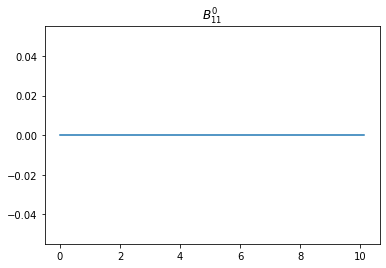

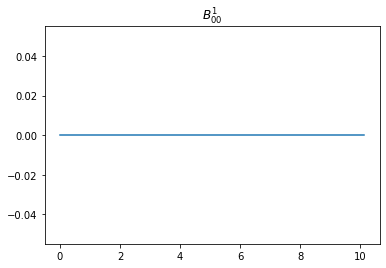

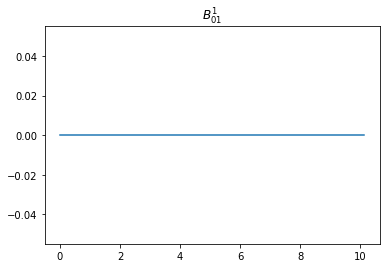

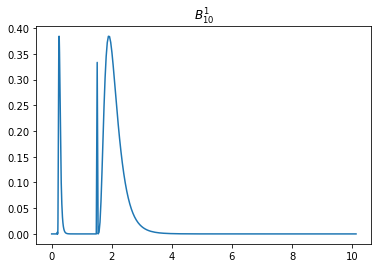

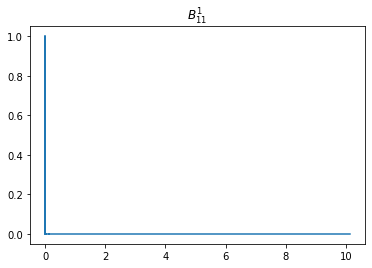

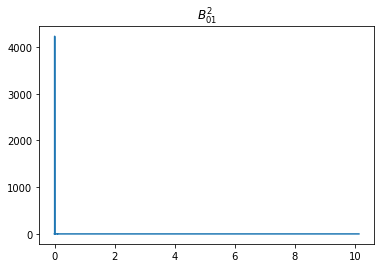

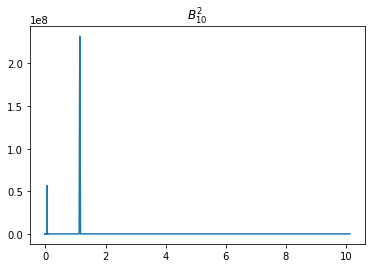

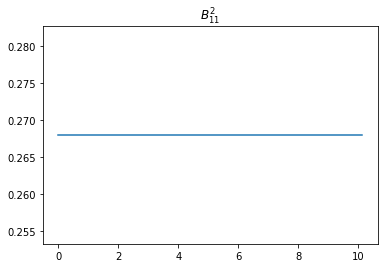

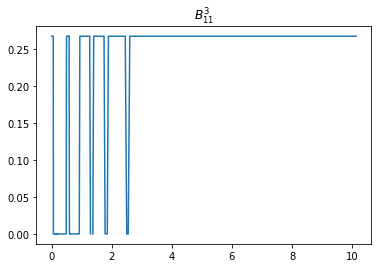

In [3]:
for m,n in itertools.product(range(3),range(3)):
    if A0[m,n] is not None:
        plt.plot(k,A0[m,n])
        plt.title(r'$A_{\rm{%d%d}}$'%(m,n))
        plt.show()
for m,a,b in itertools.product(range(4),range(2),range(2)):
    if B0[m,a,b] is not None:
        plt.plot(k,B0[m,a,b])
        plt.title(r'$B^{\rm{%d}}_{\rm{%d%d}}$'%(m,a,b))
        plt.show()

# Pdd,Pdv,Pvv from RegPT

In [4]:
k11,_,_,pdd_0,_ = np.genfromtxt('./camb_regpt/p11.dat').T
intp = interp1d(k11,pdd_0,kind='nearest')
pdd = intp(kk)

k12,_,_,pdv_0,_ = np.genfromtxt('./camb_regpt/p12.dat').T
intp = interp1d(k12,pdv_0,kind='nearest')
pdv = intp(kk)

k22,_,_,pvv_0,_ = np.genfromtxt('./camb_regpt/p22.dat').T
intp = interp1d(k22,pvv_0,kind='nearest')
pvv = intp(kk)

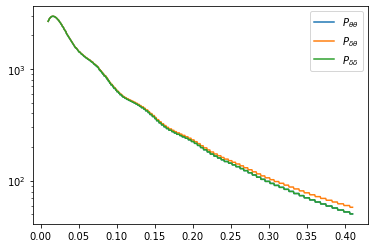

In [5]:
cut = np.where((pvv != pdd) & (pdv != pdd) & (pvv != pdv))
plt.plot(kk,pvv,label=r'$P_{\theta \theta}$')
plt.plot(kk,pdv,label=r'$P_{\delta \theta}$')
plt.plot(kk,pvv,label=r'$P_{\delta \delta}$')
plt.legend()
plt.yscale('log')
plt.show()

# TNS model

In [ ]:
def b1_z(z):
    return 0.278*((1+z)**2-6.565)+2.393


def pgdd(k,z,b1,b2):
    bs2 = -4/7*(b1-1)
    b3nl = 32/315*(b1-1)
    
    par = []
    par.append(b1**2*pdd)
    par.append(2*b1*b2*pb2d)
    par.append(2*bs2*b1*pbs2d)
    par.append(2*b3nl*pb3nl)
    par.append(b2**2*pb22)
    
    return np.sum(par,axis=0)

def pgdv(k,z,b1,b2):
    bs2 = -4/7*(b1-1)
    b3nl = 32/315*(b1-1)
    
    par = []
    par.append(b1*pdv)
    par.append(b2*pb2v)
    par.append(bs2*pbs2d)
    par.append(b3nl*pb3nl)
    
    return np.sum(par,axis=0)

def dfog(k,u,z,sigma_v):
    
    return (1+(kk*u*sigma_v)**2/2)**(-2)


def AA(k,u,z,b1,f):
    par1 = b1**3
    par2 = []
    for m,n in itertools.product(range(3),range(3)):
        if A[m,n] is not None:
            par2.append(u**(2*m)*(f/b1)**n*A[m,n])
    return par1*np.sum(par2,axis=0)

def BB(k,u,z,b1,f):
    par1 = b1**4
    par2 = []
    for m,a,b in itertools.product(range(4),range(2),range(2)):
        if B[m,a,b] is not None:
            par2.append(u**(2*m)*(-f/b1)**(a+b)*B[m,a,b])
    return par1*np.sum(par2,axis=0)

def pg(k,u,z,b1,b2,f,sigma_v):
    par1 = dfog(k,u,z,sigma_v)
    par2 = []
    par2.append(pgdd(k,z,b1,b2))
    par2.append(2*f*u**2*pgdv(k,z,b1,b2))
    par2.append(f**2*u**4*pvv)
    par2.append(AA(k,u,z,b1,f))
    par2.append(BB(k,u,z,b1,f))
    return par1*np.sum(par2,axis=0)
'''
def p(k,z,a_para,a_perp,b1,b2,f,sigma_v):
    
    a = a_perp**(2/3)*a_para**(1/3)
    FAP = a_para/a_perp
    eps = FAP**(1/3)-1
    
    k1 = k*(1+eps)/a*(1+u**2*((1+eps)**(-6)-1))**(1/2)
    u1 = u/(1+eps)**3*(1+u**2*((1+eps)**(-6)-1))**(1/2)
'''    